# Overview

Model-Based Temporal Abstraction involves simultaneuously learning
1) skill-conditioned low-level policy
2) skill-conditioned temporally abstract world model

Notation
- skill-conditioned low-level policy: $\pi_{\theta}(a_t|s_t, z)$
    - $\theta$ are parameters
    - $a_t \in A$ is current action selected by agent
    - $s_t \in S$ is current state
    - $z \in Z$ is abstract skill variable that encodes a skill

- skill-conditioned temporally abstract world model (TAWM): $p_{\psi}(s'|s,z)$ (models distribution of states agent is in after skill $z$)
    - $\psi$ parameters
    - $z$ is current skill

Note: low-level policy and TAWM not trained on rewards, reward function is provided later for planning with the learned skills 





In [377]:
# Import the necessary packages for the whole script
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Independent, kl_divergence
import numpy as np
import matplotlib.pyplot as plt
import minari
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

### Learning $\pi_{\theta}$ and $p_{\psi}$

Learning $\pi_{\theta}$ and $p_{\psi}$ requires treating skills as latent variables and optimizing the ELBO

$$
\mathcal{L}(\theta,\psi,\phi,\omega)
= \mathbb{E}_{\tau_T \sim \mathcal{D}}\!\left[
  \mathbb{E}_{q_\phi(z\,|\,\tau_T)}\!\left[
    \log \pi_\theta(\bar{a}\,|\,\bar{s}, z)
    + \log p_\psi(s_T \,|\, s_0, z)
  \right]
  - D_{\mathrm{KL}}\!\left(q_\phi(z\,|\,\tau_T)\,\|\,p_\omega(z\,|\,s_0)\right)
\right].
$$

where $\tau_T$ is a T-length subtrajectory sampled from the offline dataset $\mathcal{D}$, $\bar{s}$ and $\bar{a}$ are state and action sequences of $\tau_T$, $q_{\psi}$ is a posterior over $z$ given $\tau_T$, and $p_{\omega}$ is a prior of $z$ given $s_0$.

The first term is the log-likelihood of demonstrator actions. This ensures that the low-level policy can reproduce a demonstrator's action sequence given a skill. This forces $z$ to encode control-relevant information.

The second term is the log-likelihood of long-term state transitions. This term ensures that we learn relationships between $z$ to what possible $s_T$ could result from. the skill.

Finally, the last term is the KL divergence between skill posterior and prior (encourages compression of skills). Therefore, maximizing this ELBO makes skills $z$ explain the data and keeps the KL divergence small. This ensures that the skill is start-state predictable.

In [ ]:
# According to the paper, each layer contains 256 neurons
NUM_NEURONS = 256
# The dimension of the abstract skill variable, z
Z_DIM = 256

# Skill Posterior, q_phi
class SkillPosterior(nn.Module):
    """
    Input: sequence of skills and actions
    Output: mean and std over z

    1. Linear layer w/ ReLU activation for the state sequence
    2. Single-layer bidirectional GRU for embedded states and action sequence (concatenated)
    3. Extract mean and std of layer 2's output
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(in_features=self.state_dim, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.bi_gru = nn.GRU(input_size=NUM_NEURONS+self.action_dim, hidden_size= NUM_NEURONS//2, bidirectional=True, batch_first=True)
        self.mean = MeanNetwork(Z_DIM)
        self.std = StandardDeviationNetwork(Z_DIM)

    def forward(self, state_sequence, action_sequence):
        embedded_states = self.relu(self.fc1(state_sequence))
        concatenated = torch.cat([embedded_states, action_sequence], dim=-1)
        x, _ = self.bi_gru(concatenated) # [B, T, NUM_NEURONS]
        seq_emb = x.mean(dim=1) # [B, NUM_NEURONS]
        mean = self.mean.forward(seq_emb)
        std = self.std.forward(seq_emb)
        return mean, std

# Low-Level Skill-Conditioned Policy, pi_theta
class SkillPolicy(nn.Module):
    """
    Input: Current state and a skill, z
    Output: mean and std over a

    1. 2-layer shared network w/ ReLU activations for the state and abstract skill (concatenated)
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(in_features=self.state_dim+Z_DIM, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(self.action_dim)
        self.std = StandardDeviationNetwork(self.action_dim)
    
    def forward(self, state, z):
        c = torch.cat([state, z], dim=-1)
        x = self.relu(self.fc1(c))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std
        

# Temporally-Abstract World Model, p_psi
class TAWM(nn.Module):
    """
    Input: initial state, along with the abstract skill
    Output: mean and std over terminal state

    1. 2-layer shared network w/ ReLU activations for initial state and abstract skill (concatenated)
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim):
        super().__init__()

        self.state_dim = state_dim
        self.fc1 = nn.Linear(in_features=self.state_dim+Z_DIM, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(self.state_dim)
        self.std = StandardDeviationNetwork(self.state_dim)
    
    def forward(self, input_state, z):
        c = torch.cat([input_state, z], dim=-1)
        x = self.relu(self.fc1(c))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std

# Skill Prior, p_omega
class SkillPrior(nn.Module):
    """
    Input: Initial state, s0, in the trajectory
    Output: mean and std over the abstract skill, z

    1. 2-layer shared network w/ ReLU activations for the initial state
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim):
        super().__init__()

        self.state_dim = state_dim
        self.fc1 = nn.Linear(in_features=self.state_dim, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(Z_DIM)
        self.std = StandardDeviationNetwork(Z_DIM)
    
    def forward(self, input_state):
        x = self.relu(self.fc1(input_state))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std

class MeanNetwork(nn.Module):
    """
    Input: tensor to calculate mean
    Output: mean of input w/ dimension out_dim

    1. 2-layer network w/ ReLU activation for the first layer
    """
    def __init__(self, out_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=out_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        
        
class StandardDeviationNetwork(nn.Module):
    """
    Input: tensor to calculate std
    Output: std of input w/ dimension out_dim

    Note: the standard deviation is lower and upper bounded at 0.05 and 2.0
    - if std is 0, then log(std) -> inf
    - if std is large, then can affect training

    1. 2-layer linear network with ReLU activation after first layer and softplus after second

    """
    def __init__(self, out_dim, min_std=0.05, max_std=2.0):
        super().__init__()
        self.fc1 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, out_dim)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.min_std = min_std
        self.max_std = max_std
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        std = self.softplus(x) + self.min_std  # lower bound
        std = torch.clamp(std, max=self.max_std)
        return std


#### The Expectation-Maximization (EM) Algorithm

Since calculating the true posterior of $z$ given $\tau_T$ is intractable, we infer $q_{\psi}(z|\tau_T)$.

1. E-Step:
- Update $\psi$ w/gradient descent so that KL divergence between $q_\psi$ and true posterior is minimized

2. M-Step:
- Fixing $q_{\psi}$, update ($\theta, \psi, \omega$) s.t. ELBO is maximized using gradient ascent.


##### E-Step (Update $\psi$)

In this step, we want to minimize 

$$
\mathbb{E}_{\mathcal{T}_T\sim\mathcal{D}}
\Bigg[
\mathbb{E}_{z\sim q_\phi}
\bigg[
\log \frac{q_\phi\!\left(z\mid \bar{s},\bar{a}\right)}
{\pi_\theta\!\left(\bar{a}\mid \bar{s}, z\right)\,p_\omega\!\left(z\mid s_0\right)}
\bigg]
\Bigg]
$$

Equivalently, we want to minimize $\mathcal{KL}(q_{\psi}||p)$ where $p$, the true posterior is 

$$
p(z \mid \bar{s}, \bar{a}) = \frac{1}{\eta}\,\pi_\theta(\bar{a}\mid \bar{s}, z)\,p_\omega(z\mid s_0).
$$


##### M-Step (Update $\theta$, $\psi$, $\omega$)

In this step, we want to update $\theta$, $\psi$, and $\omega$ using gradient ascent to maximize the ELBO from above.

Both steps are trained using an Adam optimizer.


##### Dataset 1: AntMaze Medium

In [379]:
# Loads the AntMaze dataset in Minari format
ant_maze_dataset = minari.load_dataset('D4RL/antmaze/medium-play-v1')

In [380]:
print(ant_maze_dataset[0].actions.shape)
print(ant_maze_dataset[0].observations.keys())
print(ant_maze_dataset[0].observations["observation"].shape)

(1000, 8)
dict_keys(['achieved_goal', 'desired_goal', 'observation'])
(1001, 27)


In [381]:
# B, the number of subtrajectories per batch (from paper)
B = 100

# T, the length of each subtrajectory (from paper)
T = 9

# AntMaze state and action dims (from Minari)
state_dim = 27
action_dim = 8

# Initialize the models
q_phi = SkillPosterior(state_dim=state_dim, action_dim=action_dim).to(device)
pi_theta = SkillPolicy(state_dim=state_dim, action_dim=action_dim).to(device)
p_psi = TAWM(state_dim=state_dim).to(device)
p_omega = SkillPrior(state_dim=state_dim).to(device)

In [382]:
class TrainingDataset(Dataset):
    """
    Input: LoadedMinari dataset and the length of the number of actions in each subtrajectory (T)
    Output: Dictionary with keys "s0, state_sequence, action_sequence, and sT"

    Finds all episodes that have at least T actions. Then, for each of those episodes, creates a sliding window to create subtrajectories w/ T actions
    """
    def __init__(self, ant_maze_dataset, T):
        self.T = T
        self.subtrajectories = []

        for ep in ant_maze_dataset.iterate_episodes():
            s = ep.observations["observation"]
            a = ep.actions
            l = len(s)
            if l < T + 1:
                continue
            
            # Consider skipping timesteps so that subtrajectories don't overlap that much
            for t in range(0, l - T):
                s0 = s[t]
                state_sequence = s[t: t + T]
                action_sequence = a[t: t + T]
                sT = s[t + T]
                self.subtrajectories.append((s0, state_sequence, action_sequence, sT))

    def __len__(self):
        return len(self.subtrajectories)

    def __getitem__(self, idx):
        s0, state_sequence, action_sequence, sT = self.subtrajectories[idx]
        return {
            "s0": torch.as_tensor(s0, dtype=torch.float32),
            "state_sequence": torch.as_tensor(state_sequence, dtype=torch.float32),
            "action_sequence": torch.as_tensor(action_sequence, dtype=torch.float32),
            "sT": torch.as_tensor(sT, dtype=torch.float32)
        }
    
def collate(batch):
    # Vertically stacks each of the components of the subtrajectories such that the first dimension is the batch
    return {
        "s0": torch.stack([b["s0"] for b in batch], 0),
        "state_sequence": torch.stack([b["state_sequence"] for b in batch], 0),
        "action_sequence": torch.stack([b["action_sequence"] for b in batch], 0),
        "sT": torch.stack([b["sT"] for b in batch], 0)
    }

# Create the dictionary of subtrajectories
dataset = TrainingDataset(ant_maze_dataset, T)

# Iterator w/ groups of subtrajectories from the dataset of size B 
loader = DataLoader(dataset, batch_size=B, shuffle=True, collate_fn=collate)

In [ ]:
def compute_e_loss(batch):
    s0  = batch["s0"]               
    S   = batch["state_sequence"]   
    A   = batch["action_sequence"]  
    Bsz, T, _ = S.shape

    # Sampling z using the reparameterization trick where z = mu(tau) + std(tau) * epsilon
    mu_q, std_q = q_phi(S, A) # [B, z_dim]
    eps = torch.randn_like(mu_q)
    z = (mu_q + std_q * eps)      

    # Freeze the weights of the low-level skill-conditioned policy, pi_theta
    with torch.no_grad():
        z_bt = z.unsqueeze(1).expand(Bsz, T, -1) # [B, T, z_dim]
        # Flatten time dimension since pi_theta does not the expect extra dim ([B * T, s_dim])
        Sf = S.reshape(Bsz*T, -1)
        Zf = z_bt.reshape(Bsz*T, -1)
        mu_pi, std_pi = pi_theta(Sf, Zf)     
        # Restore time dimension ([B, T, a_dim])
        mu_pi  = mu_pi.view(Bsz, T, -1)
        std_pi = std_pi.view(Bsz, T, -1)
        # Build a MVN over independent actions at each timestep of each batch and sum log_probs across action_dim
        pi_dist = Independent(Normal(mu_pi, std_pi), 1)
        # Compute the log probability of observed actions
        log_pi = pi_dist.log_prob(A) # ([B, T])    

    # Freeze the weights of the skill prior, p_omega
    with torch.no_grad():
        # Find the distribution of the abstract skill given start states (mu_pr & std_pr: [B, z_dim])
        mu_pr, std_pr = p_omega(s0)  
        # Build a MVN over independent skills at each timestep of each batch and sum log_probs across z_dim
        prior_dist = Independent(Normal(mu_pr, std_pr), 1)
        # Compute the log-probability over the sampled skills using the prior
        log_p_omega = prior_dist.log_prob(z)   

    post_dist = Independent(Normal(mu_q, std_q), 1)
    # Compute the log-probability over the sampled skills using the inferred posterior
    log_q = post_dist.log_prob(z)              

    # Calculate the E-objective
    e_obj = (log_pi.sum(dim=1) + log_p_omega - log_q)
    e_loss = -e_obj.mean() # minimize the negative objective
    return e_loss



def compute_m_loss(batch):
    s0  = batch["s0"]               
    S   = batch["state_sequence"]   
    A   = batch["action_sequence"] 
    sT  = batch["sT"]               
    Bsz, T, Sdim = S.shape

    # Freeze the weights of the inferred posterior, only update omega, psi, and theta
    with torch.no_grad():
        mu_q, std_q = q_phi(S, A)        # [B, z_dim]
        eps = torch.randn_like(mu_q)
        # same reparameterization trick as E-loss
        z = (mu_q + std_q * eps)  

    z_bt = z.unsqueeze(1).expand(Bsz, T, -1)
    # Flatten time dimension since pi_theta does not the expect extra dim ([B * T, s_dim])
    Sf = S.reshape(Bsz*T, -1)
    Zf = z_bt.reshape(Bsz*T, -1)
    mu_pi, std_pi = pi_theta(Sf, Zf)    
    # Restore time dimension ([B, T, a_dim])     
    mu_pi = mu_pi.reshape(Bsz, T, -1)
    std_pi = std_pi.reshape(Bsz, T, -1)
    # Build a MVN over independent actions at each timestep of each batch and sum log_probs across action_dim
    pi_dist = Independent(Normal(mu_pi, std_pi), 1)
    log_pi = pi_dist.log_prob(A)               

    # Zs: [B, T, z_dim]
    mu_T, std_T = p_psi(s0, z)
    # Build a MVN over independent terminal states at each timestep of each batch and sum log_probs across state_dim     
    ppsi_dist = Independent(Normal(mu_T, std_T), 1)
    # Compute the log-probability over the observed terminal states using the TAWM
    log_p_psi = ppsi_dist.log_prob(sT)          

    # Find the distribution of the abstract skill given start states (mu_pr & std_pr: [B, z_dim])
    mu_pr, std_pr = p_omega(s0)                
    # Build a MVN over independent skills at each timestep of each batch and sum log_probs across z_dim
    prior_dist = Independent(Normal(mu_pr, std_pr), 1)
    # Compute the log-probability over the sampled skills using the prior
    log_p_omega = prior_dist.log_prob(z)   

    # sum to find join log-likelihood of the whole sequence
    obj = log_pi.sum(dim=1) + log_p_psi + log_p_omega   
    m_loss = -obj.mean()
    return m_loss


In [384]:

def skill_model_training():
    q_phi.to(device).train()
    pi_theta.to(device).train()
    p_psi.to(device).train()
    p_omega.to(device).train()

    e_optimizer = optim.Adam(q_phi.parameters(), lr=5e-5)
    m_optimizer = optim.Adam(list(pi_theta.parameters()) + list(p_psi.parameters()) + list(p_omega.parameters()), lr=5e-5)

    for batch in loader:
        for p in q_phi.parameters():
            p.requires_grad_(True)
        for m in (pi_theta, p_psi, p_omega):
            for p in m.parameters():
                p.requires_grad_(False)
                
        e_optimizer.zero_grad(set_to_none=True)
        e_loss = compute_e_loss(batch)
        e_loss.backward()
        e_optimizer.step()

        # freeze q_phi
        for p in q_phi.parameters():
            p.requires_grad_(False)
        for m in (pi_theta, p_psi, p_omega):
            for p in m.parameters():
                p.requires_grad_(True)
                
        m_optimizer.zero_grad(set_to_none=True)
        m_loss = compute_m_loss(batch)
        m_loss.backward()
        m_optimizer.step()

        print(f"E-Loss = {e_loss}")
        print(f"M-Loss = {m_loss}")


    
    

In [ ]:

def skill_model_training(
    loader,
    q_phi, pi_theta, p_psi, p_omega,
    e_lr=5e-5, m_lr=5e-5,
    epochs=50,
    e_steps=1, m_steps=1,
    grad_clip=1.0 # prevents runaway gradients
):
    # Skill model training setup
    q_phi.to(device)
    pi_theta.to(device)
    p_psi.to(device)
    p_omega.to(device)

    e_optimizer = torch.optim.Adam(q_phi.parameters(), lr=e_lr)
    m_optimizer = torch.optim.Adam(list(pi_theta.parameters()) + list(p_psi.parameters()) + list(p_omega.parameters()), lr=m_lr)

    e_curve = []   
    m_curve = []   

    for epoch in range(1, epochs+1):
        # Running e_loss, m_loss, and batches in current epoch
        e_running, m_running, nb = 0.0, 0.0, 0

        for batch in loader:
            # Rebuilds dictionary but moves tensors to the device
            batch = {k: v.to(device) for k, v in batch.items()}
            nb += 1

            # In E-step, train the posterior while freezing other parameters
            q_phi.train()
            pi_theta.eval()
            p_psi.eval()
            p_omega.eval()

            for p in q_phi.parameters(): 
                p.requires_grad_(True)
            for m in (pi_theta, p_psi, p_omega):
                for p in m.parameters(): 
                    p.requires_grad_(False)

            # For the e-step, 
            for _ in range(e_steps):
                # Resent gradients
                e_optimizer.zero_grad(set_to_none=True)
                e_loss = compute_e_loss(batch)
                e_loss.backward() 
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(q_phi.parameters(), grad_clip)
                e_optimizer.step() # Update the parameters of the posterior

            e_running += e_loss.item()

            # Freeze posterior weights, update all other weights
            q_phi.eval()
            pi_theta.train()
            p_psi.train()
            p_omega.train()

            for p in q_phi.parameters(): 
                p.requires_grad_(False)
            for m in (pi_theta, p_psi, p_omega):
                for p in m.parameters(): 
                    p.requires_grad_(True)

            for _ in range(m_steps):
                # Reset gradients
                m_optimizer.zero_grad(set_to_none=True)
                m_loss = compute_m_loss(batch)
                m_loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(list(pi_theta.parameters()) + list(p_psi.parameters()) + list(p_omega.parameters()), grad_clip)
                m_optimizer.step() # Update theta, psi, and omega

            m_running += m_loss.item()

        # Calculate the average losses over all the batches in the epoch
        e_epoch = e_running / max(1, nb)
        m_epoch = m_running / max(1, nb)
        e_curve.append(e_epoch)
        m_curve.append(m_epoch)
        print(f"[Epoch {epoch:03d}/{epochs}]  E: {e_epoch:.4f}   M: {m_epoch:.4f}")



    plt.figure(figsize=(6,4))
    plt.plot(e_curve, label="E-loss")
    plt.plot(m_curve, label="M-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("EM training losses")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return e_curve, m_curve


[Epoch 001/50]  E: 34.6321   M: 587.2893
[Epoch 002/50]  E: 18.7181   M: 564.2154
[Epoch 003/50]  E: 14.3338   M: 555.5850
[Epoch 004/50]  E: 11.8708   M: 551.0396
[Epoch 005/50]  E: 10.2931   M: 548.5038
[Epoch 006/50]  E: 9.2057   M: 546.7163
[Epoch 007/50]  E: 8.4040   M: 545.4306
[Epoch 008/50]  E: 7.7825   M: 544.3742
[Epoch 009/50]  E: 7.2769   M: 543.5378
[Epoch 010/50]  E: 6.8484   M: 542.9135
[Epoch 011/50]  E: 6.4756   M: 542.3097
[Epoch 012/50]  E: 6.1471   M: 541.7917
[Epoch 013/50]  E: 5.8573   M: 541.3920
[Epoch 014/50]  E: 5.6009   M: 540.9686
[Epoch 015/50]  E: 5.3650   M: 540.6116
[Epoch 016/50]  E: 5.1603   M: 540.2273
[Epoch 017/50]  E: 4.9698   M: 539.9982
[Epoch 018/50]  E: 4.7942   M: 539.7353
[Epoch 019/50]  E: 4.6350   M: 539.4810
[Epoch 020/50]  E: 4.4839   M: 539.2131
[Epoch 021/50]  E: 4.3414   M: 538.9758
[Epoch 022/50]  E: 4.2132   M: 538.7621
[Epoch 023/50]  E: 4.0907   M: 538.6684
[Epoch 024/50]  E: 3.9821   M: 538.4522
[Epoch 025/50]  E: 3.8715   M: 538.

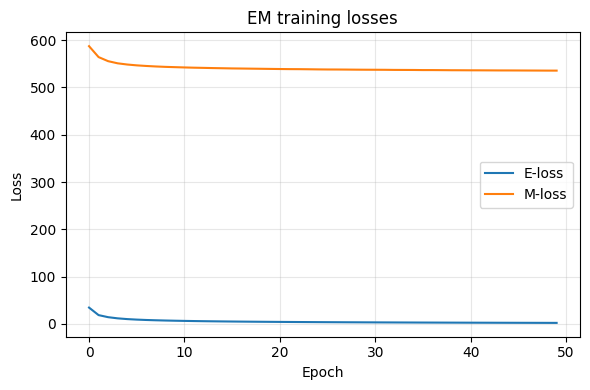

([34.632104935280736,
  18.718106401495394,
  14.333753334923136,
  11.870766926953388,
  10.293108207167636,
  9.205655097172805,
  8.404015556670304,
  7.782496626444763,
  7.276920088113947,
  6.848445854860268,
  6.475573981876838,
  6.147124711596858,
  5.8573420286726865,
  5.60089017624212,
  5.364965634688081,
  5.160325909638097,
  4.969755971805599,
  4.794241927900622,
  4.63496806736985,
  4.483944812930995,
  4.341430921915435,
  4.213216802843184,
  4.090713386402202,
  3.982116294656988,
  3.8714676368775773,
  3.77109343508841,
  3.6782950373452907,
  3.5837183880398324,
  3.4986904569604165,
  3.4164115324983046,
  3.3396665169672963,
  3.2639087533875606,
  3.1909066144234997,
  3.1168312637662776,
  3.0545678949550017,
  2.9806281963873427,
  2.924166094080324,
  2.8640310614143023,
  2.8064153846293616,
  2.747507080512658,
  2.6942042776389563,
  2.643141311008944,
  2.595454361687538,
  2.542034269951515,
  2.494077418269749,
  2.4488521351047363,
  2.406893505953

In [388]:
skill_model_training(loader, q_phi, pi_theta, p_psi, p_omega)

In [ ]:
H = 40
K = 1000
L = 3
N_keep = 200
N_iters = 10
tau = 30